<a href="https://colab.research.google.com/github/tejaspradhan/Graph-Neural-Networks/blob/main/hiv-project/gnn_hiv_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installations

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title
# Install rdkit
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO
 
 
logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)
 
 
def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """
 
    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )
 
    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)
 
    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return
 
        logger.info("force re-install")
 
    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)
 
    logger.info("python version: {}".format(python_version))
 
    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)
 
    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')
 
    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')
 
    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python==3.7.3",
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")
 
    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))
 
 
if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.12
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit
done
rdkit-2020.09.1 installation finished!


In [3]:
! pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
! pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
! pip install -q torch-cluster -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
! pip install -q torch-geometric

     |████████████████████████████████| 7.9 MB 8.1 MB/s 
     |████████████████████████████████| 3.5 MB 9.2 MB/s 
     |████████████████████████████████| 2.3 MB 3.9 MB/s 
     |████████████████████████████████| 370 kB 8.2 MB/s 
     |████████████████████████████████| 482 kB 58.1 MB/s 
     |████████████████████████████████| 41 kB 776 kB/s 


## Importing Libraries

In [4]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
import torch.nn.functional as F 
import torch_geometric
from torch_geometric.data import Dataset, Data
from torch_geometric.nn import GATConv, Linear, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.loader import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm

## EDA

In [5]:
## Original data

In [7]:
data = pd.read_csv('/content/HIV_train.csv')

In [ ]:
data.shape

(37128, 4)

In [ ]:
data.groupby('HIV_active')['smiles'].count()

HIV_active
0    35850
1     1278
Name: smiles, dtype: int64

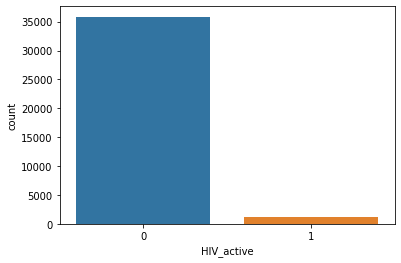

In [ ]:
sns.countplot(x=data['HIV_active'])

In [ ]:
## oversampled data

In [8]:
data = pd.read_csv('https://raw.githubusercontent.com/tejaspradhan/Graph-Neural-Networks/main/data/HIV_train_oversampled.csv')

In [9]:
data.head()

,Unnamed: 0,index,smiles,activity,HIV_active
0,3999,3999,O=C(Nc1ccc(C=Cc2ccc(NC(=O)c3ccc(N=Nc4cc(S(=O)(...,CM,1
1,4000,4000,N#CCCN(CCC#N)c1ccc(C=C2SC(=S)NC2=O)cc1,CI,0
2,4001,4001,CC(C)=C(OP(C)(I)(N(C)C)N(C)C)C(C)(C)C(=O)N(C)C,CI,0
3,4002,4002,COc1cc2cccc(N=Cc3ccccc3Cl)c2cc1OC,CI,0
4,4003,4003,O=C(Cc1ccccc1)Nn1c(-c2ccccc2)nc2ccccc2c1=O,CM,1


In [10]:
data.columns

Index(['Unnamed: 0', 'index', 'smiles', 'activity', 'HIV_active'], dtype='object')

In [11]:
data.shape

(71634, 5)

In [12]:
data.groupby('HIV_active')['smiles'].count()

HIV_active
0    35850
1    35784
Name: smiles, dtype: int64

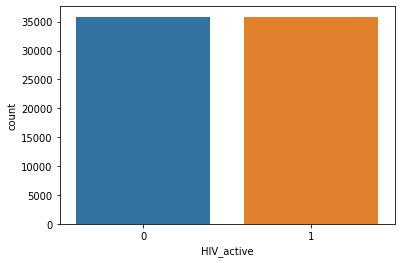

In [13]:
sns.countplot(x = data['HIV_active'])
# Dataset is highly imbalanced 

In [14]:
smiles_strings = data['smiles'][:12].values
molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_strings]

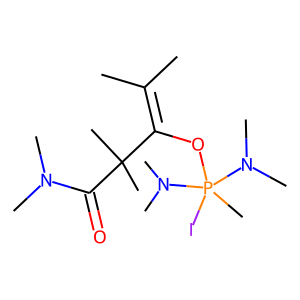

In [18]:
image = Draw.MolToImage(molecules[2])
image

In [ ]:
grid = Draw.MolsToGridImage(molecules,molsPerRow = 3, subImgSize =(512,512))

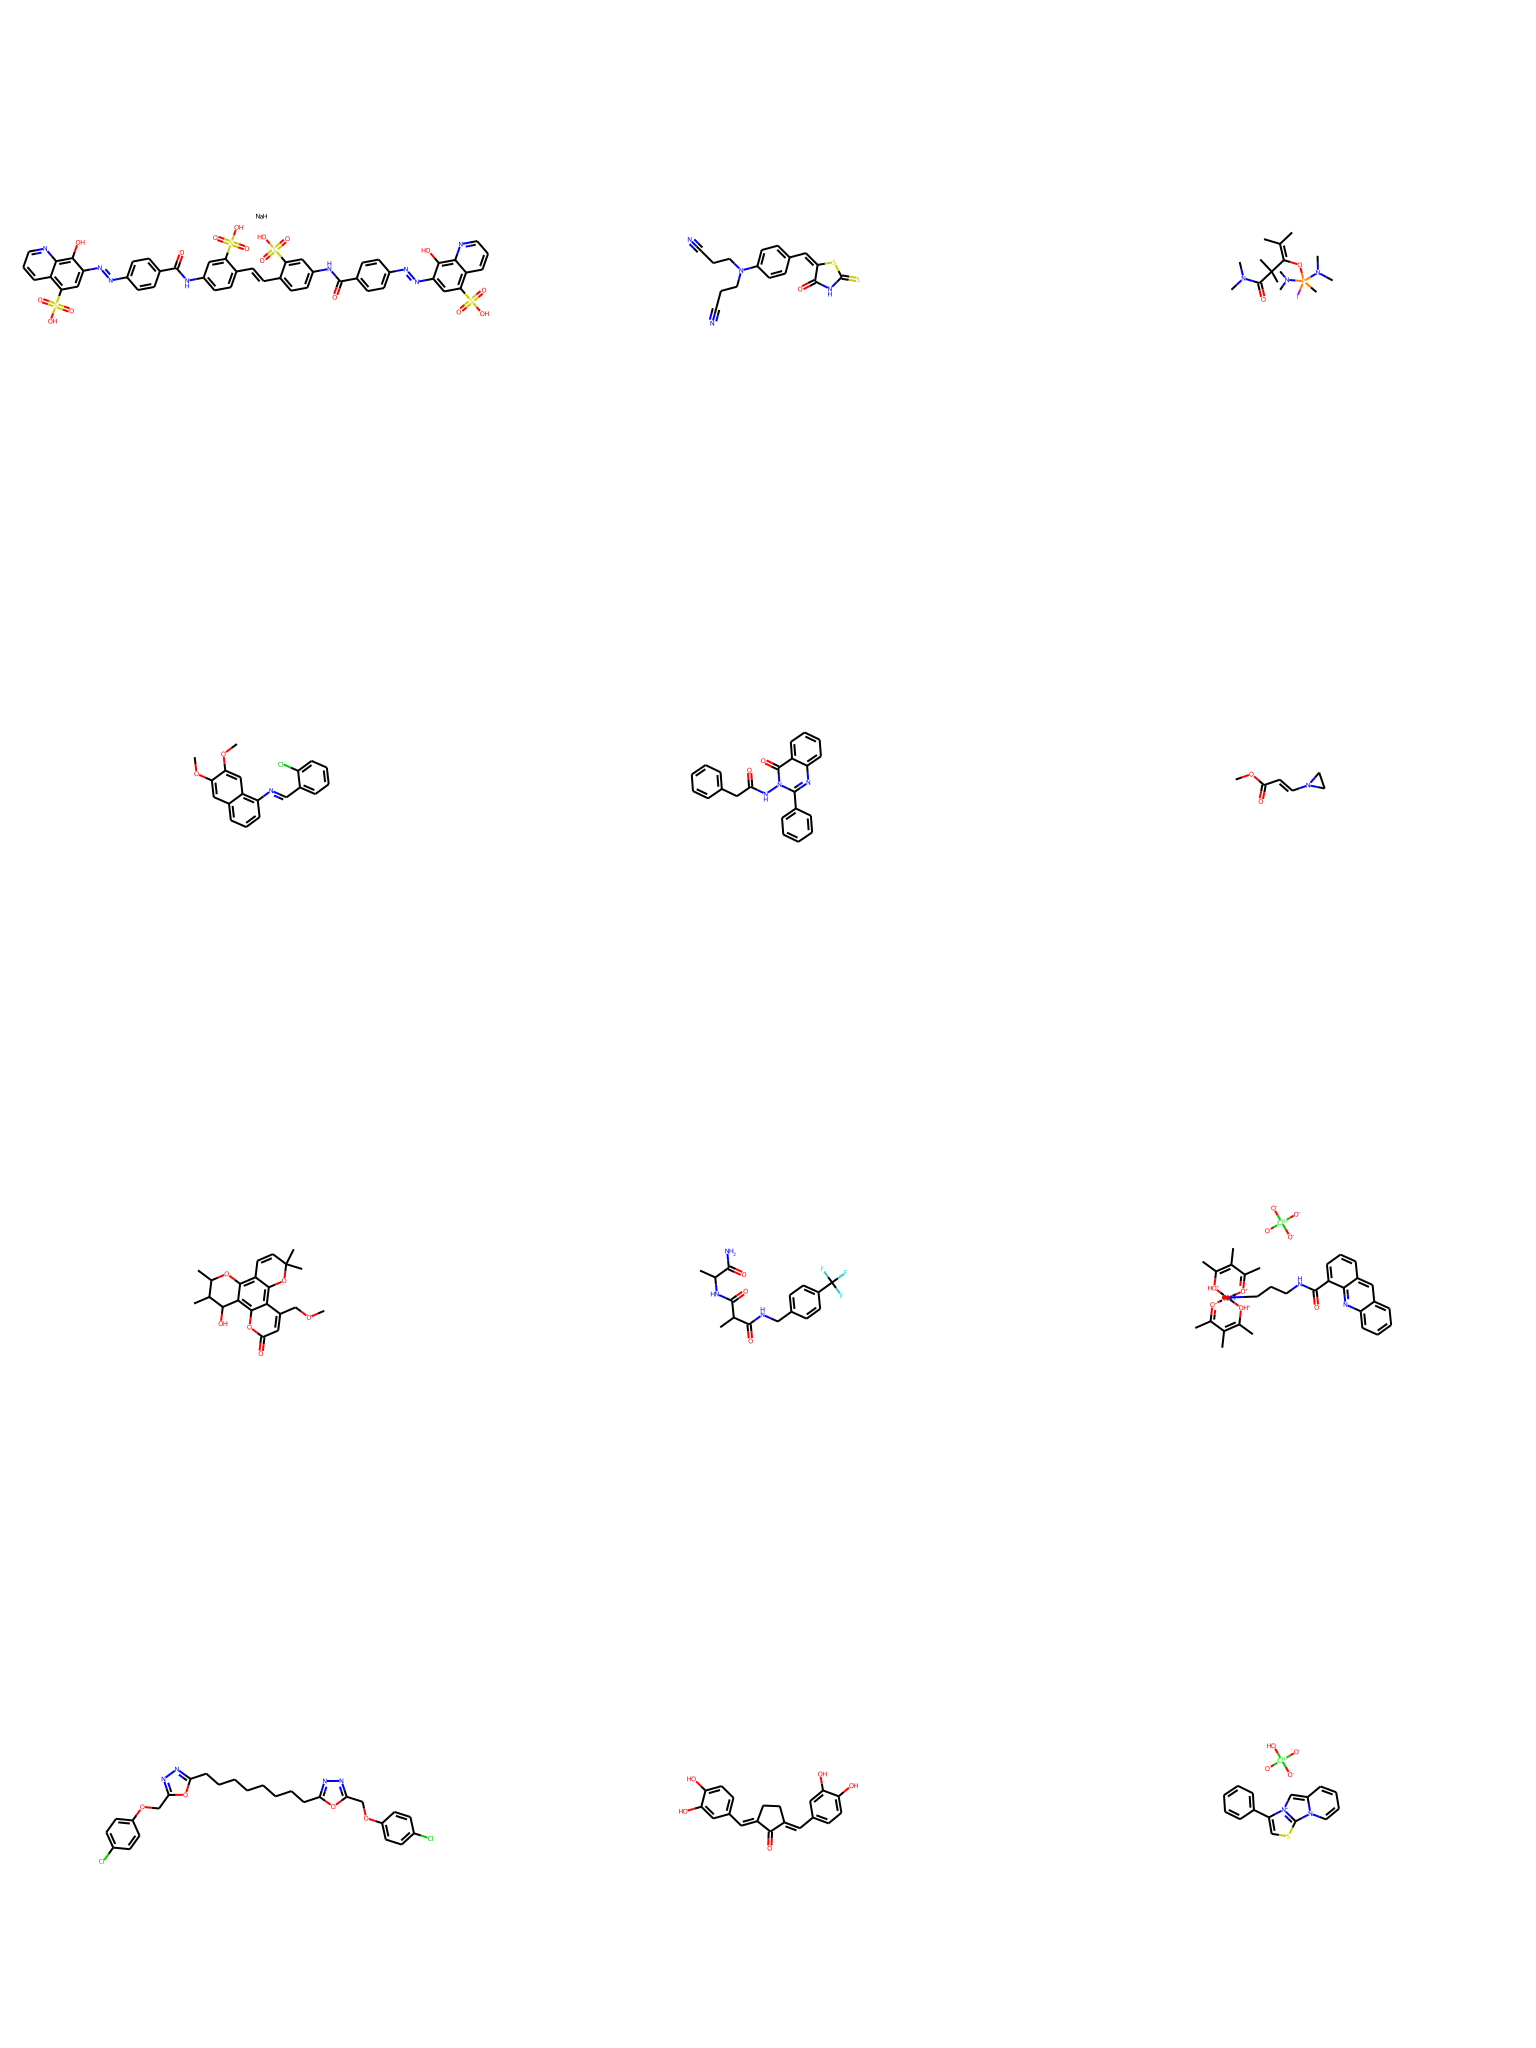

In [ ]:
grid

## Creating Custom Graph Dataset from CSV File

**Important**
Before running the next cell create a directory structure as follows : 

        |- data
              |- raw
                    |- HIV.csv (data csv file)

In [19]:
class HIVDataset(Dataset):
    def __init__(self, root, filename, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.filename = filename
        super(HIVDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return self.filename

    @property
    def processed_file_names(self):
        return 'not_implemented.pt'

    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0])
        print(self.raw_paths)
        for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            mol_obj = Chem.MolFromSmiles(mol["smiles"])
            # Get node features
            node_feats = self._get_node_features(mol_obj)
            # Get edge features
            edge_feats = self._get_edge_features(mol_obj)
            # Get adjacency info
            edge_index = self._get_adjacency_info(mol_obj)
            # Get labels info
            label = self._get_labels(mol["HIV_active"])

            # Create data object
            data = Data(x=node_feats, 
                        edge_index=edge_index,
                        edge_attr=edge_feats,
                        y=label,
                        smiles=mol["smiles"]
                        ) 
            if self.test:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_test_{index}.pt'))
            else:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{index}.pt'))

    def _get_node_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]
        """
        all_node_feats = []

        for atom in mol.GetAtoms():
            node_feats = []
            # Feature 1: Atomic number        
            node_feats.append(atom.GetAtomicNum())
            # Feature 2: Atom degree
            node_feats.append(atom.GetDegree())
            # Feature 3: Formal charge
            node_feats.append(atom.GetFormalCharge())
            # Feature 4: Hybridization
            node_feats.append(atom.GetHybridization())
            # Feature 5: Aromaticity
            node_feats.append(atom.GetIsAromatic())
            # Feature 6: Total Num Hs
            node_feats.append(atom.GetTotalNumHs())
            # Feature 7: Radical Electrons
            node_feats.append(atom.GetNumRadicalElectrons())
            # Feature 8: In Ring
            node_feats.append(atom.IsInRing())
            # Feature 9: Chirality
            node_feats.append(atom.GetChiralTag())

            # Append node features to matrix
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        return torch.tensor(all_node_feats, dtype=torch.float)

    def _get_edge_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of edges, Edge Feature size]
        """
        all_edge_feats = []

        for bond in mol.GetBonds():
            edge_feats = []
            # Feature 1: Bond type (as double)
            edge_feats.append(bond.GetBondTypeAsDouble())
            # Feature 2: Rings
            edge_feats.append(bond.IsInRing())
            # Append node features to matrix (twice, per direction)
            all_edge_feats += [edge_feats, edge_feats]

        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)

    def _get_adjacency_info(self, mol):
        """
        We could also use rdmolops.GetAdjacencyMatrix(mol)
        but we want to be sure that the order of the indices
        matches the order of the edge features
        """
        edge_indices = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_indices += [[i, j], [j, i]]

        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.t().to(torch.long).view(2, -1)
        return edge_indices

    def _get_labels(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))   
        return data

In [20]:
train_dataset = HIVDataset(root='data/',filename='HIV_train_oversampled.csv')
test_dataset = HIVDataset(root='data/',filename='HIV_test.csv')

Processing...


['data/raw/HIV_train_oversampled.csv']


100%|██████████| 71634/71634 [02:20<00:00, 508.95it/s]
Done!
Processing...


['data/raw/HIV_test.csv']


100%|██████████| 3999/3999 [00:07<00:00, 541.13it/s]
Done!


In [21]:
train_dataset

HIVDataset(71634)

In [22]:
test_dataset

HIVDataset(3999)

In [23]:
train_dataset[0].x.shape
# 9 node features

torch.Size([19, 9])

In [24]:
train_dataset[0].y.shape

torch.Size([1])

In [25]:
train_dataset[0].edge_index.t().shape # 2 edge featurs 

torch.Size([40, 2])

CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21


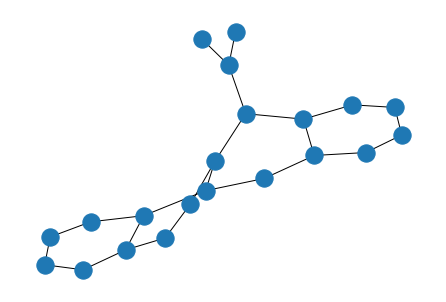

In [27]:
import networkx as nx

data = train_dataset[2]
g = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(g)
print(data.smiles)

## Constructing the GNN for this Dataset 

In [ ]:
class GNN(torch.nn.Module):
  def __init__(self,feature_size):
    super(GNN, self).__init__()
    num_classes=1
    embedding_size=1024
    self.conv1 = GATConv(feature_size,embedding_size, heads=3, dropout =0.3)
    self.head_transform1 = Linear(embedding_size*3, embedding_size)
    self.pool1 = TopKPooling(embedding_size,ratio=0.8)

    self.conv2 = GATConv(embedding_size, embedding_size, heads=3, dropout =0.3)
    self.head_transform2 = Linear(embedding_size*3, embedding_size)
    self.pool2 = TopKPooling(embedding_size,ratio=0.5)

    self.conv3 = GATConv(embedding_size, embedding_size, heads=3, dropout =0.3)
    self.head_transform3 = Linear(embedding_size*3, embedding_size)
    self.pool3 = TopKPooling(embedding_size,ratio=0.2)

    self.linear1 = Linear(embedding_size*2,1024)
    self.linear2 = Linear(1024,num_classes)

  def forward(self, x, edge_attr,edge_index,batch_index):
    x = self.conv1(x,edge_index)
    x = self.head_transform1(x)

    x,edge_index,edge_attr,batch_index, _ , _ = self.pool1(x,edge_index,None, batch_index)

    x1 = torch.cat([gmp(x,batch_index),gap(x,batch_index)],dim=1)

    x = self.conv2(x,edge_index)
    x = self.head_transform2(x)

    x,edge_index,edge_attr,batch_index, _ , _ = self.pool2(x,edge_index,None, batch_index)

    x2 = torch.cat([gmp(x,batch_index),gap(x,batch_index)],dim=1)

    x = self.conv3(x,edge_index)
    x = self.head_transform3(x)

    x,edge_index,edge_attr,batch_index, _ , _ = self.pool3(x,edge_index,None, batch_index)

    x3 = torch.cat([gmp(x,batch_index),gap(x,batch_index)],dim=1)

    x=x1+x2+x3

    x = self.linear1(x).relu()
    x = F.dropout(x,p=0.5, training=self.training) 
    x = self.linear2(x)

    return x

## Training the GNN

In [ ]:
model = GNN(train_dataset[0].x.shape[1])

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/GNN_HIV/models/model-hiv-15epochs.pt'))

<All keys matched successfully>

In [ ]:
model.to('cuda')

GNN(
  (conv1): GATConv(9, 1024, heads=3)
  (head_transform1): Linear(3072, 1024, bias=True)
  (pool1): TopKPooling(1024, ratio=0.8, multiplier=1.0)
  (conv2): GATConv(1024, 1024, heads=3)
  (head_transform2): Linear(3072, 1024, bias=True)
  (pool2): TopKPooling(1024, ratio=0.5, multiplier=1.0)
  (conv3): GATConv(1024, 1024, heads=3)
  (head_transform3): Linear(3072, 1024, bias=True)
  (pool3): TopKPooling(1024, ratio=0.2, multiplier=1.0)
  (linear1): Linear(2048, 1024, bias=True)
  (linear2): Linear(1024, 1, bias=True)
)

In [ ]:
# Defining loss and optimiser 
weights = torch.tensor([1,10],dtype=torch.float32).to('cuda')
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05,momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.95)

In [ ]:
BATCH_SIZE = 256
EPOCHS=35

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
def train(model, train_loader, optimizer, loss_fn):
    # Enumerate over the data
    all_preds = []
    all_labels = []
    running_loss = 0.0
    step = 0
    for _, batch in enumerate(tqdm(train_loader)):
        batch.to('cuda')  
        optimizer.zero_grad() 
        # forward pass
        pred = model(batch.x.float(), batch.edge_attr.float(),batch.edge_index, batch.batch) 
        # backward pass 
        loss = torch.sqrt(loss_fn(torch.squeeze(pred), batch.y.float()))
        loss.backward()  
        optimizer.step()  

        # Update tracking
        running_loss += loss.item()
        step += 1
        all_preds.append(np.rint(torch.sigmoid(pred).cpu().detach().numpy()))
        all_labels.append(batch.y.cpu().detach().numpy())
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    # print(all_preds)
    acc= accuracy_score(all_labels, all_preds)
    return running_loss/step, acc


In [ ]:
losses = []
accs = []
for epoch in range(EPOCHS):
  loss, accuracy = train(model, train_loader, optimizer,loss_fn)
  losses.append(loss)
  accs.append(accuracy)
  print(f"Epoch : {epoch+1} , Loss : {loss}, Accuracy : {accuracy}")

100%|██████████| 280/280 [01:28<00:00,  3.16it/s]


Epoch : 1 , Loss : 0.7550430793847357, Accuracy : 0.7069827177038837


100%|██████████| 280/280 [01:33<00:00,  3.00it/s]


Epoch : 2 , Loss : 0.746377660546984, Accuracy : 0.7163916575927632


100%|██████████| 280/280 [01:29<00:00,  3.11it/s]


Epoch : 3 , Loss : 0.7408842544470514, Accuracy : 0.7225200323868554


100%|██████████| 280/280 [01:28<00:00,  3.16it/s]


Epoch : 4 , Loss : 0.734988177887031, Accuracy : 0.7277968562414496


100%|██████████| 280/280 [01:28<00:00,  3.15it/s]


Epoch : 5 , Loss : 0.7322961722101484, Accuracy : 0.7312449395538432


100%|██████████| 280/280 [01:28<00:00,  3.16it/s]


Epoch : 6 , Loss : 0.7313813279782023, Accuracy : 0.7314124577714494


100%|██████████| 280/280 [01:28<00:00,  3.15it/s]


Epoch : 7 , Loss : 0.7277511781879834, Accuracy : 0.732710723957897


100%|██████████| 280/280 [01:28<00:00,  3.16it/s]


Epoch : 8 , Loss : 0.7235703717385019, Accuracy : 0.7379037887036882


100%|██████████| 280/280 [01:28<00:00,  3.17it/s]


Epoch : 9 , Loss : 0.7220030229006494, Accuracy : 0.7395231314738812


100%|██████████| 280/280 [01:28<00:00,  3.15it/s]


Epoch : 10 , Loss : 0.7234269880822727, Accuracy : 0.7386855403858503


100%|██████████| 280/280 [01:28<00:00,  3.18it/s]


Epoch : 11 , Loss : 0.7301438610468592, Accuracy : 0.7323617276712175


100%|██████████| 280/280 [01:28<00:00,  3.17it/s]


Epoch : 12 , Loss : 0.7195493962083545, Accuracy : 0.7411145545411397


100%|██████████| 280/280 [01:28<00:00,  3.17it/s]


Epoch : 13 , Loss : 0.7173698414649282, Accuracy : 0.7414635508278192


100%|██████████| 280/280 [01:28<00:00,  3.17it/s]


Epoch : 14 , Loss : 0.718611801309245, Accuracy : 0.7412541530558114


100%|██████████| 280/280 [01:28<00:00,  3.17it/s]


Epoch : 15 , Loss : 0.7153906160167285, Accuracy : 0.7443253203785912


100%|██████████| 280/280 [01:28<00:00,  3.16it/s]


Epoch : 16 , Loss : 0.7153792098164559, Accuracy : 0.743152692855348


100%|██████████| 280/280 [01:28<00:00,  3.15it/s]


Epoch : 17 , Loss : 0.7118315524288586, Accuracy : 0.7470056118602898


100%|██████████| 280/280 [01:28<00:00,  3.16it/s]


Epoch : 18 , Loss : 0.7080831951328687, Accuracy : 0.7493229472038417


100%|██████████| 280/280 [01:28<00:00,  3.15it/s]


Epoch : 19 , Loss : 0.7089758400406156, Accuracy : 0.7493229472038417


100%|██████████| 280/280 [01:28<00:00,  3.17it/s]


Epoch : 20 , Loss : 0.7126324093767575, Accuracy : 0.7475919256219113


100%|██████████| 280/280 [01:31<00:00,  3.06it/s]


Epoch : 21 , Loss : 0.7074023808751787, Accuracy : 0.7504816148756177


100%|██████████| 280/280 [01:28<00:00,  3.15it/s]


Epoch : 22 , Loss : 0.7131422106708799, Accuracy : 0.7479548817600581


100%|██████████| 280/280 [01:28<00:00,  3.18it/s]


Epoch : 23 , Loss : 0.710803374009473, Accuracy : 0.7476617248792473


100%|██████████| 280/280 [01:27<00:00,  3.20it/s]


Epoch : 24 , Loss : 0.707367611357144, Accuracy : 0.7498255018566602


100%|██████████| 280/280 [01:27<00:00,  3.20it/s]


Epoch : 25 , Loss : 0.708675066275256, Accuracy : 0.7502024178462741


100%|██████████| 280/280 [01:27<00:00,  3.18it/s]


Epoch : 26 , Loss : 0.7062167780739921, Accuracy : 0.7515286037356562


100%|██████████| 280/280 [01:27<00:00,  3.20it/s]


Epoch : 27 , Loss : 0.7127054635967527, Accuracy : 0.7452745902783594


100%|██████████| 280/280 [01:27<00:00,  3.20it/s]


Epoch : 28 , Loss : 0.7113466733268329, Accuracy : 0.7490577100259653


100%|██████████| 280/280 [01:27<00:00,  3.20it/s]


Epoch : 29 , Loss : 0.718482980132103, Accuracy : 0.7424267805790546


100%|██████████| 280/280 [01:27<00:00,  3.19it/s]


Epoch : 30 , Loss : 0.708021754026413, Accuracy : 0.7517659212105983


100%|██████████| 280/280 [01:27<00:00,  3.19it/s]


Epoch : 31 , Loss : 0.7064949993576323, Accuracy : 0.7522963955663512


100%|██████████| 280/280 [01:27<00:00,  3.19it/s]


Epoch : 32 , Loss : 0.7034625004444803, Accuracy : 0.7551162855627216


100%|██████████| 280/280 [01:27<00:00,  3.20it/s]


Epoch : 33 , Loss : 0.6992904171347618, Accuracy : 0.7580478543708294


100%|██████████| 280/280 [01:27<00:00,  3.19it/s]


Epoch : 34 , Loss : 0.7048044779470989, Accuracy : 0.7547393695731077


100%|██████████| 280/280 [01:27<00:00,  3.19it/s]

Epoch : 35 , Loss : 0.697781968329634, Accuracy : 0.7576988580841499


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/GNN_HIV/models/model-hiv-50epochs.pt")

In [ ]:
import matplotlib.pyplot as plt

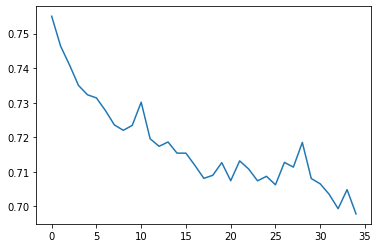

In [ ]:
plt.plot(range(35), losses)

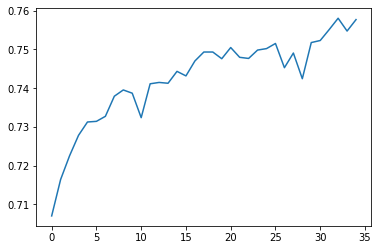

In [ ]:
plt.plot(range(35), accs)

In [ ]:
model.eval()
with torch.no_grad():
  test_preds = []
  test_labels = []
  running_loss = 0.0
  steps =0 
  for _, batch in enumerate(tqdm(test_loader)):
    batch.to('cuda')
    pred = model(batch.x.float(), batch.edge_attr.float(),batch.edge_index, batch.batch)
    # print(batch.y)
    loss = loss_fn(pred, batch.y)
    test_preds.append(np.argmax(pred.cpu().detach().numpy(),axis=1))
    test_labels.append(batch.y.cpu().detach().numpy())
    running_loss += loss.item()
    steps+=1
  test_preds = np.concatenate(test_preds).ravel()
  test_labels = np.concatenate(test_labels).ravel()
  acc= accuracy_score(test_labels, test_preds)
  print(f'\nTest Loss : {running_loss/steps} \n Test Accuracy : {acc}')

100%|██████████| 16/16 [00:09<00:00,  1.61it/s]


Test Loss : 1.2761140167713165 
 Test Accuracy : 0.046261565391347834


# Training Saved Model 

In [ ]:
model = GNN(train_dataset[0].x.shape[1])
model.load_state_dict(torch.load('/content/drive/MyDrive/GNN_HIV/models/model-hiv-10epochs.pt'))

<All keys matched successfully>

In [ ]:
model

GNN(
  (conv1): GATConv(9, 1024, heads=3)
  (head_transform1): Linear(3072, 1024, bias=True)
  (pool1): TopKPooling(1024, ratio=0.8, multiplier=1.0)
  (conv2): GATConv(1024, 1024, heads=3)
  (head_transform2): Linear(3072, 1024, bias=True)
  (pool2): TopKPooling(1024, ratio=0.5, multiplier=1.0)
  (conv3): GATConv(1024, 1024, heads=3)
  (head_transform3): Linear(3072, 1024, bias=True)
  (pool3): TopKPooling(1024, ratio=0.2, multiplier=1.0)
  (linear1): Linear(2048, 1024, bias=True)
  (linear2): Linear(1024, 2, bias=True)
)